# opencv tutorial

tesseract 4.0의 작동 성능 향상을 위해 opencv 및 preprocessing을 적용할 예정이며, 이를 위한 opencv 실습 과정을 기록하겠음.  
중간 중간 해결하지 못한 error나 향상 방안 등을 꾸준히 업데이트하여 기록할 예정  
작업환경 : WSL 2 / Ubuntu 20.04 / python3.8.2 / opencv v.4.2.0

In [140]:
#필요한 라이브러리 가져오기

import argparse
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from PIL import Image

In [170]:
cv2.__version__

'4.2.0'

In [2]:
#현재 디렉토리 확인 후 작업 디렉토리 변경

print("before:%s"%os.getcwd())
os.chdir("/home/qsoo/jupyter/1_opencv")
print("after: %s"%os.getcwd())

before:/root
after: /home/qsoo/jupyter/1_opencv


In [3]:
#이미지 가져오기

img = cv2.imread('example.jpg')
print(f'shape:{img.shape}') #Shape: (433, 450, 3) BGR형식으로 이미지 로딩
print(f'dtype:{img.dtype}') #dtype: unint8(unsigned 8)

shape:(711, 1920, 3)
dtype:uint8


## 1. 이미지 조작

'\n\nlinux에서 cv2.imshow()사용시 오류 발생\n해결하는 방법 존재 / plt.imshow()사용 가능\n\n'

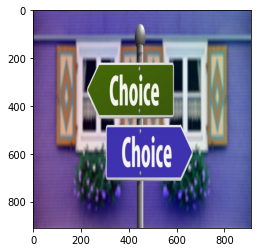

In [4]:
#이미지 resize

width, height = 910, 910
resized_img = cv2.resize(img,(width, height))
plt.imshow(resized_img, cmap ='gray')


'''

linux에서 cv2.imshow()사용시 오류 발생
해결하는 방법 존재 / plt.imshow()사용 가능

'''

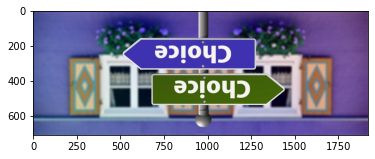

In [5]:
#이미지 flip

flip_img = cv2.flip(img,-1) # 0 - x축 기준 / 1 - y축 기준 / -1 - x,y 동시에
plt.imshow(flip_img)

In [6]:
#이미지 저장
cv2.imwrite('img_compressed.png', img, [cv2.IMWRITE_PNG_COMPRESSION, 0]) #낮은 압축률
#(0,9) 숫자가 크면 파일 크기는 작지만 디코딩 프로세스 느려짐

cv2.imwrite('img_compressed2.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, 0]) #낮은 압축률
#(0,100) 숫자가 크면 artifact 양이 감소 / 고품질

save_img = cv2.imread('img_compressed.png')
assert save_img.all() == img.all() #원본과 동일한지 비교

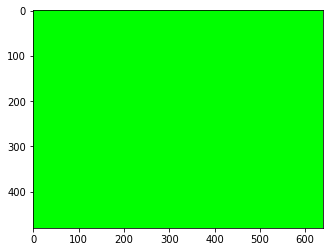

In [7]:
#행렬조작 ROI(Region of Interest)

image = np.full((480, 640, 3), (0,255,0), np.uint8) #녹색

'''
image = np.full((480, 640, 3), 255, np.uint8) #흰색
image = np.full((480, 640, 3), (0,255,0), np.uint8) #녹색
image = np.full((480, 640, 3), (0,255,255), np.uint8) #노란색
image = np.full((480, 640, 3), (0,0,255), np.uint8) #빨간색
'''

# (480, 640, 3) : height, width, channel / 색조합

plt.imshow(image)

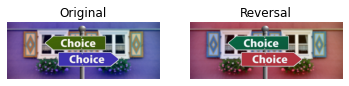

In [8]:
#Channel 변경

origin_img = cv2.imread('example.jpg')
reversal_img = origin_img.copy()
reversal_img[:,:,[2,0]] = reversal_img[:,:,[0,2]] #red channel과 blue channel 변경

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(origin_img)
ax1.set_title('Original')
ax1.axis('off')

ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(reversal_img)
ax2.set_title('Reversal')
ax2.axis('off')

plt.show()

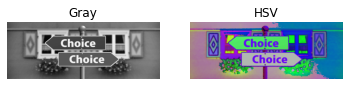

In [9]:
#색 공간 변환

gray_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
hsv_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2HSV)

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(gray_img, cmap = 'gray')
ax1.set_title('Gray')
ax1.axis('off')

ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(hsv_img)
ax2.set_title('HSV')
ax2.axis('off')

plt.show()


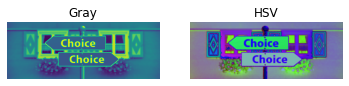

In [10]:
#색 공간 변환

gray_img1 = cv2.cvtColor(reversal_img, cv2.COLOR_BGR2GRAY)
hsv_img1 = cv2.cvtColor(reversal_img, cv2.COLOR_BGR2HSV)

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(gray_img1)
ax1.set_title('Gray')
ax1.axis('off')

ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(hsv_img1)
ax2.set_title('HSV')
ax2.axis('off')

plt.show()

#cmap=gray 안해주면 밑처럼 나옴

## 2. fixel histogram

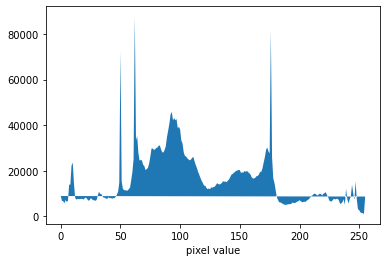

In [11]:
#픽셀 히스토그램으로 확인

hist, bins = np.histogram(img, 256, [0,255])
plt.fill(hist)
plt.xlabel('pixel value')
plt.show()

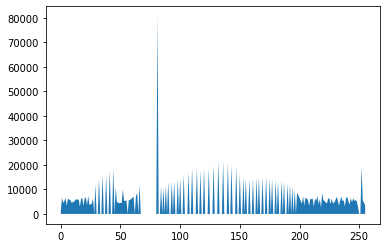

In [12]:
#대비가 낮은 이미지 조정을 위해 히스토그램 평활화

hist_equal = cv2.equalizeHist(gray_img)
hist, bins = np.histogram(hist_equal, 256, [0,255])
plt.fill_between(range(256), hist, 0)
plt.show()

#cv2.equalizeHist 사용을 위해서는 channel 1 --> gray scale 이용

## 3. filter 적용

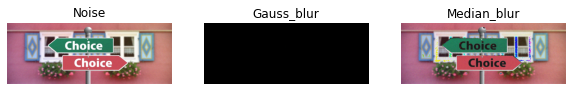

In [13]:
#Noise 제거

#[0,1]사이의 범위의 부동소수점 데이터 타입으로 변환
image = cv2.imread('example.jpg').astype(np.float32) / 255

#Noise 추가
noise = (image + 0.2*np.random.rand(*img.shape).astype(np.float32))

gauss_blur = cv2.GaussianBlur(noise.astype(np.uint8),(7,7), 0)
median_blur = cv2.medianBlur((noise*255).astype(np.uint8), 7)
noise = noise.clip(0,1)

# plt.imshow(noise[:,:,[2,1,0]])
# plt.imshow(gauss_blur[:,:,[2,1,0]])
# plt.imshow(median_blur[:,:,[2,1,0]])
# plt.show()

fig = plt.figure(figsize=(10,10))
rows = 1
cols = 3

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(noise[:,:,[2,1,0]])
ax1.set_title('Noise')
ax1.axis('off')

ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(gauss_blur[:,:,[2,1,0]])
ax2.set_title('Gauss_blur')
ax2.axis('off')

ax3 = fig.add_subplot(rows,cols,3)
ax3.imshow(median_blur[:,:,[2,1,0]])
ax3.set_title('Median_blur')
ax3.axis('off')

plt.show()

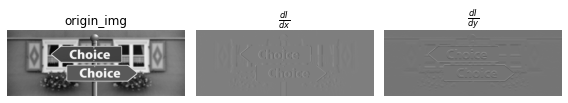

In [14]:
#sobel filter : 3*3 이미지 필터를 이용하여 중심을 기준으로 앞뒤의 변화량 검출
#이미지 경사도 계산방법

origin_img = cv2.imread('example.jpg', 0) #gray scale

#sobel filter
dx = cv2.Sobel(origin_img, cv2.CV_32F, 1, 0)
dy = cv2.Sobel(origin_img, cv2.CV_32F, 0, 1)

#visualization

plt.figure(figsize=(8,3))

plt.subplot(131)
plt.axis('off')
plt.title('origin_img')
plt.imshow(origin_img, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.imshow(dx, cmap='gray')
plt.title(r'$\frac{dI}{dx}$')

plt.subplot(133)
plt.axis('off')
plt.title(r'$\frac{dI}{dy}$')
plt.imshow(dy, cmap='gray')
plt.tight_layout()
plt.show()

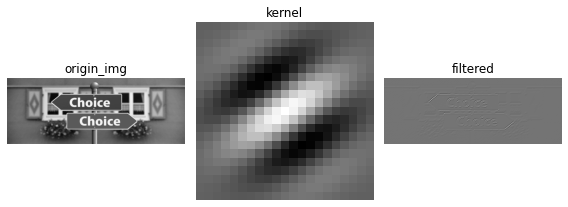

In [15]:
#Gabor filter : 코사인파로 변화된 2D 가우시안 커널을 갖는 선형 필터
#외곽선 검출 기능 / 사인,코사인 함수로 모듈화된 가우시안 필터

origin_img=cv2.imread('example.jpg', 0).astype(np.float32)
origin_img=origin_img / 255

#Gabor filter
kernel = cv2.getGaborKernel((21,21), 5, 1, 10, 1, 0, cv2.CV_32F)
#[커널크기, 가우시안 표준편차, 파형 방향, 파형 길이, 공간비율, 위상]

kernel /=math.sqrt((kernel*kernel).sum())

filtered = cv2.filter2D(origin_img, -1, kernel)

plt.figure(figsize=(8,3))

plt.subplot(131)
plt.axis('off')
plt.title('origin_img')
plt.imshow(origin_img, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.imshow(kernel, cmap='gray')
plt.title('kernel')

plt.subplot(133)
plt.axis('off')
plt.title('filtered')
plt.imshow(filtered, cmap='gray')

plt.tight_layout()
plt.show()

#이미지의 방향을 아는 경우 edge 검출에 유용

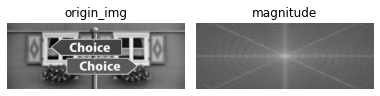

In [16]:
#이산 푸리에 변환 : 주로 신호처리에서 이용, 이미지를 공간 표현 -> 주파수 / 역에 사용

origin_img = cv2.imread('example.jpg', 0).astype(np.float32) # gray scale
origin_img = origin_img / 255

 

# DFT

fft = cv2.dft(origin_img, flags=cv2.DFT_COMPLEX_OUTPUT)

 

# spectrum visualization

shifted = np.fft.fftshift(fft, axes=[0,1])
magnitude = cv2.magnitude(shifted[:,:,0], shifted[:,:,1])
magnitude = np.log(magnitude)

 

plt.figure(figsize=(8,2))

plt.subplot(131)
plt.axis('off')
plt.title('origin_img')
plt.imshow(origin_img, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.title('magnitude')
plt.imshow(magnitude, cmap='gray')

plt.tight_layout()

## 4. Threshold

값 : 200.0


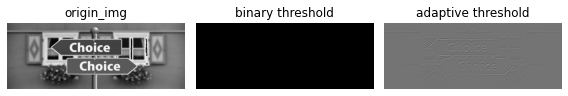

'\n\n'

In [155]:
#image threshold

#basic threshold
threshold, mask = cv2.threshold(origin_img, 200, 1, cv2.THRESH_BINARY)
print('값 :',threshold)

#adapt threshold
adapt_mask = cv2.adaptiveThreshold
(origin_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 0)

plt.figure(figsize=(8,3))

plt.subplot(131)
plt.axis('off')
plt.title('origin_img')
plt.imshow(origin_img, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.title('binary threshold')
plt.imshow(mask, cmap='gray')


plt.subplot(133)
plt.axis('off')
plt.title('adaptive threshold')
plt.imshow(filtered, cmap='gray')

plt.tight_layout()
plt.show()


'''
현재 adaptivethreshold type error 발생중 - 확인 후 수정 예정
'''

## 5. text detection을 위한 이미지 변형

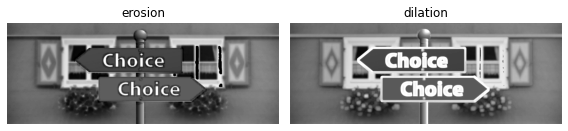

In [173]:
#Erosion and Dilation

'''
Eriosion : and 연산으로 축소
Dilation : or 연산으로 팽창
'''

kernel = np.ones((5,5), np.uint8) #커널크기, 5X5

#cv2.erode(원본이미지, 수행커널, 반복횟수)
erosion_img = cv2.erode(origin_img, kernel, iterations=2)

#cv2.dilate(원본이미지, 수행커널, 반복횟수)
dilation_img = cv2.dilate(origin_img, kernel, iterations=2)


plt.figure(figsize=(8,3))

plt.subplot(121)
plt.axis('off')
plt.title('erosion')
plt.imshow(erosion_img, cmap='gray')

plt.subplot(122)
plt.axis('off')
plt.title('dilation')
plt.imshow(dilation_img, cmap='gray')

plt.tight_layout()
plt.show()

In [43]:
#kernel matrix 만들기

def makeKernel() :
    M1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)) #직사각형 모양
    M2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5)) #십자가 모양
    
    print(M1)
    print(M2)
    
makeKernel()

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


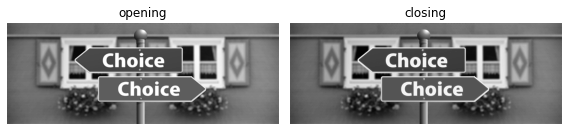

In [45]:
#opening과 closing

'''
opening : erosion -> dilation
Closing : dilation -> erosion

'''

#cv2.morphologyEX(원본이미지, 변형 오퍼레이션 종류, 수행커널)
opening_img = cv2.morphologyEx(origin_img, cv2.MORPH_OPEN, kernel)
closing_img = cv2.morphologyEx(origin_img, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(8,3))

plt.subplot(121)
plt.axis('off')
plt.title('opening')
plt.imshow(opening_img, cmap='gray')

plt.subplot(122)
plt.axis('off')
plt.title('closing')
plt.imshow(closing_img, cmap='gray')

plt.tight_layout()
plt.show()

## 6. contours

In [159]:
#finding contour
'''
1)threshold는 위에서 사용한 global threshold 이용

2)_, contours, hierarchy = 
    cv2.findContours(대상이미지, contour 추출모드, contour 근사방법)
    
3)cv2.drawContours(경계 나타낼 이미지, 이미지에 그릴 contours,
    그릴 contours index, contours 선 색(BGR), 선의 두께)
'''
ret, thr = cv2.threshold(gray_img, 200, 1, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    
contours_img = cv2.drawContours(reversal_img, contours, -1, (0,255,0), 3)

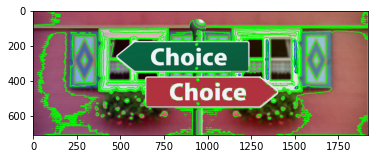

In [160]:
plt.imshow(contours_img)